In [2]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer 
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
import seaborn as sns
import missingno as msno
import re
%matplotlib inline
# nltk.download('punkt')
# nltk.download('vader_lexicon')
# nltk.download('wordnet')

In [3]:
# data=[]
# with open("Electronics_5.json","r") as f:
#     for i in f:
#         data.append(json.loads(i))

In [5]:
data = pd.read_json('../data/Electronics_5.json',lines=True)
data.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,AO94DHGC771SJ,0528881469,amazdnu,"[0, 0]",We got this GPS for my husband who is an (OTR)...,5,Gotta have GPS!,1370131200,"06 2, 2013"
1,AMO214LNFCEI4,0528881469,Amazon Customer,"[12, 15]","I'm a professional OTR truck driver, and I bou...",1,Very Disappointed,1290643200,"11 25, 2010"
2,A3N7T0DY83Y4IG,0528881469,C. A. Freeman,"[43, 45]","Well, what can I say. I've had this unit in m...",3,1st impression,1283990400,"09 9, 2010"
3,A1H8PY3QHMQQA0,0528881469,"Dave M. Shaw ""mack dave""","[9, 10]","Not going to write a long review, even thought...",2,"Great grafics, POOR GPS",1290556800,"11 24, 2010"
4,A24EV6RXELQZ63,0528881469,Wayne Smith,"[0, 0]",I've had mine for a year and here's what we go...,1,"Major issues, only excuses for support",1317254400,"09 29, 2011"


In [7]:
data.shape

(1689188, 9)

In [6]:
df = data.loc[:,['reviewText','summary','overall']].copy()

<AxesSubplot:xlabel='overall', ylabel='count'>

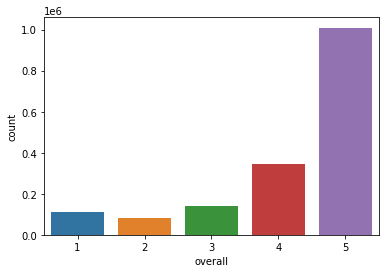

In [56]:
sns.countplot(x="overall",data=df)

In [7]:
df = df[df['overall'] != 3]
df['overall'].value_counts()

5    1009026
4     347041
1     108725
2      82139
Name: overall, dtype: int64

<AxesSubplot:xlabel='overall', ylabel='count'>

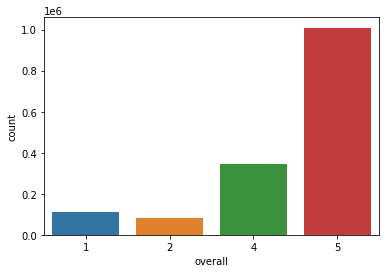

In [58]:
sns.countplot(x="overall",data=df)

### Defining Labels
let's make it that:
- 'overall' > 3   == Positive Sentiment (1) <br>
- 'overall' == 3 == Neutral Sentiment (0)  <br>
- 'overall' < 3   == Negative Sentiment (-1)<br>

<AxesSubplot:xlabel='sentiment', ylabel='count'>

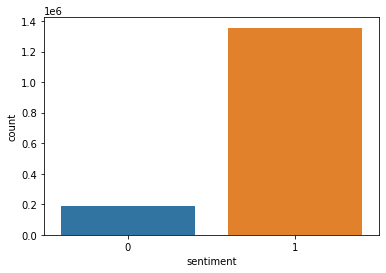

In [8]:
df['sentiment'] = df['overall'].apply(lambda x : 0 if x<=2 else 1 )
sns.countplot(x="sentiment",data=df)

In [60]:
df['sentiment'].value_counts()

1    1356067
0     190864
Name: sentiment, dtype: int64

In [54]:
# plt.figure(figsize = (12,18))

# plt.subplot(421)
# g1 = sns.distplot(df[df['sentiment'] == 1]['reviewText'].apply(lambda x : len(x.split(" "))),
#                  hist = False, label = 'Text')

# g1.set_title('Positive sentiment Word count distribution', fontsize = 14)
# g1.set(xlabel='Word Count')


# plt.subplot(423)
# g3 = sns.distplot(df[df['sentiment'] == 0]['reviewText'].apply(lambda x : len(x.split(" "))),
#                  hist = False, label = 'Text')

# g3.set_title('Negative sentiment Word count distribution', fontsize = 14)
# g3.set(xlabel='Word Count')

# plt.subplots_adjust(wspace = 0.2, hspace = 0.4, top = 0.9)
# plt.legend()
# plt.show()

In [9]:
import imblearn
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
undersample = RandomUnderSampler(sampling_strategy='majority')
X_under, y_under = undersample.fit_resample(df[['reviewText']], df['sentiment'])

In [62]:
y_under.value_counts()

1    190864
0    190864
Name: sentiment, dtype: int64

C:\Users\Outhm\AppData\Roaming\Python\Python36\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='sentiment', ylabel='count'>

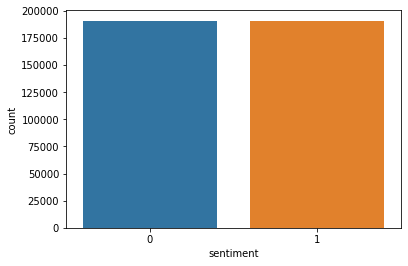

In [63]:
sns.countplot(y_under)

### Cleaning text

In [10]:
def clean_text(text):
    import re
    #lower text
    text = text.lower()
    #decontract
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    #removing numbers and special characters
    text = re.sub("[^A-Za-z ]+","",text)
    #remove links
    text = re.sub(r"(?:\@|http?\://|https?\://|www)\S+", "", text)

    
    #tokenize text
    text_tokenized = nltk.word_tokenize(text,language='english')
    
    #removing stopwords
    negtion_words = ['no','not','none','no','one','nobody','nothing','neither','nowhere','never','doesn\'t','isn\'t','wasn\'t','shouldn\'t','wouldn\'t','couldn\'t','won\'t','can\'t','don\'t']
    ## keeping negation words since it affects the sentiment of a text
    my_stopwords = set(negtion_words) ^ set(stopwords.words('english'))
    
    text_tokenized = [w for w in text_tokenized if w not in my_stopwords]
    
    #lemmetizing text
    lemmatizer = WordNetLemmatizer()
    text_lemmatized = [lemmatizer.lemmatize(w) for w in text_tokenized]
    
    #removing stopwords
    return ' '.join(text_lemmatized)

In [11]:
X_under['reviewTextCleaned'] = X_under['reviewText'].apply(clean_text)
# X_under['summaryCleaned'] = X_under['summary'].apply(clean_text)

In [22]:
# X_under.to_csv('X_under_cleaned.csv',encoding='utf-8',index=False)

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_under['reviewTextCleaned'], y_under, test_size = 0.25)

In [13]:
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (286296,)
X_test shape: (95432,)
y_train shape: (286296,)
y_test shape: (95432,)


In [14]:
tfidf = TfidfVectorizer(ngram_range=(1,2))
tfidf.fit(X_train)
X_train_vect = tfidf.transform(X_train)
X_test_vect = tfidf.transform(X_test)

### 1. Logistic Regression

In [76]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_train_vect,y_train)

C:\Users\Outhm\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression()

In [79]:
lr_preds = lr.predict(X_test_vect)
print(classification_report(y_test,lr_preds))

              precision    recall  f1-score   support

           0       0.91      0.90      0.90     47666
           1       0.90      0.91      0.90     47766

    accuracy                           0.90     95432
   macro avg       0.90      0.90      0.90     95432
weighted avg       0.90      0.90      0.90     95432



In [80]:
print("===== Logistic Regression Confusion Matrix =====")
confusion_matrix(y_test,lr_preds)

===== OVR Logistic Regression Confusion Matrix =====


array([[42922,  4744],
       [ 4437, 43329]], dtype=int64)

In [85]:
lr_pipline = Pipeline([
    ('tfidf',tfidf),
    ('ovr_lr',lr)
])
lr_pipline.predict([clean_text('the quality is terrible')])

array([0], dtype=int64)

In [92]:
lr_pipline.predict([clean_text(
    """
    This monitor is definitely a good value. Does it have superb color and contrast? No. Does it boast the best refresh rate on the market? No. But if you're tight on money, this thing looks and preforms great for the money. It has a Matte screen which does a great job at eliminating glare. The chassis it's enclosed within is absolutely stunning. It features a VGA and and HDMI port. The screen automatically detects signals and turns on when a source is turned on. When the selected source turns off it quickly scans and switches to any other sources. If no connections are available it goes into standby automatically. The power chord is a good 6 or more feet and easy to wrap with half of it being very thin wire. The ON LED is not distracting or too bright. When it's off it looks like a borderless monitor. And unlike what other people say it does have tilt, just not forward or left to right. It stands up straight or leans back. Unfortunately it doesn't have VESA mount holes, but under 100 you can't be that serious about your monitor setup. Small text has some problems fully rendering when using VGA so I recommend using HDMI. If you use the Windows 10 settings to configure how text is displayed though it fixes this, but not all will know how to do that. It doesn't have speaker, and I am thankful that most monitors don't. This monitor has A LOT of settings for gaming, night use, color adjustments, and general settings and all can be saved into 3 different gaming profiles. You can even change what settings appear in the quick menu. When u press any of the menu buttons, the menu pops up and clearly illustrates all the buttons. This monitors menus are super easy to understand and navigate and that's a rarity in its own. Also worth noting; it can display crosshairs and display the monitors current refresh rate. It also packs FreeSync for AMD graphics card users. If you only have DVI, you can get DVI to HDMI chords as long as your computer's video out supports it. The base and monitor couple together with one screw that features a hand flap so you don't need a screw diver if you don't want to use one. It is decently sturdy and the screen doesn't distort even when pressed on with strong pressure. The base is quite large, but wont be a problem for most. I haven't noticed any screen delay compared to my 300 dollar 1ms response time monitor (and I'm pretty picky). It's contrast is a little flat in some scenarios but appears much more dynamic in games, especially with some tweaking. With that said, I like that it looks flat when working on documents because it makes it much easier to focus.All in all, this monitor is filled with a good balance of features and looks like a very solid 1080p 75Hz IPS screen for any monitor under $160, let alone the $80 I paid. If you don't absolutely need a better refresh rate and aren't planning on spending more than 200 dollars then I would say just buy this monitor. It's durable, feature packed, and looks fantastic in all use-case scenarios. I'd give it 1000 stars if I could.
    """
    )
    ])

array([1], dtype=int64)

In [93]:
lr_pipline.predict([clean_text(
    """
    I very rarely write reviews, but am so disappointed with this monitor, that I felt the need to warn others. Originally bought this last year to use for school and work. After a few weeks, started having issues with it turning off and repeatedly blinking in mid-use, as well as dead pixels in the middle of the screen. Contacted Amazon, and they sent a replacement and I returned the original. Again, a few weeks of perfect operation. Then on the replacement unit, the power and menu buttons stopped working. The only way to turn on and off was to physically unplug the unit. Contacted Amazon again, and they referred me to the manufacturer. After several attempts, I finally got a hold of a person. They said they would look at, but I would have to ship it back on my own dime, and they would not replace it. I declined (mostly because I didn't have a box to pack it in, and was severely unimpressed with customer service).So I continued using it for several months with few issues. I stopped using it earlier this year, mostly because I got tired of the physical unplugging, and started using an old TV instead. Just now, went to fire it up again for my wife to use. After not touching or using it for the last few months, the screen is cracked in the middle, and as far as I'm concerned is unusable. And no, this is not a case of "oops I dropped it and now I'm going to blame the hardware." I have other Acer electronics, and have been for the most part satisfied, but this monitor has been nothing but problems. Would rate less than 1 star if possible.
    """
)
    ])

array([0], dtype=int64)

In [87]:
import pickle
pickle.dump(lr_pipline,open("amazon_lr_model.pkl","wb"))

### 2. Multinomal Naive Bayes

In [17]:
from sklearn.naive_bayes import MultinomialNB
mnb = MultinomialNB()
mnb.fit(X_train_vect,y_train)

In [16]:
mnb_preds = mnb.predict(X_test_vect)
print(classification_report(y_test,mnb_preds))

              precision    recall  f1-score   support

           0       0.85      0.91      0.88     47540
           1       0.91      0.84      0.87     47892

    accuracy                           0.88     95432
   macro avg       0.88      0.88      0.88     95432
weighted avg       0.88      0.88      0.88     95432



In [94]:
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 0.24.1.
